## LLM-as-Judge for Generation part of RAG

In [ ]:
%pip install pandas matplotlib seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

In [3]:
file_paths = {
    'Qwen3-235B': './generations/llm-as-judge-qwen-3.csv',
    'DeepSeek-R1-671B': './generations/llm-as-judge-deepseek-r1.csv',
    'GigaChat-2-Max': './generations/llm-as-judge-gigachat-2-max.csv'
}

score_columns = ['correctness', 'completeness', 'relevance', 'clarity', 'reasoning']
all_data = []

for model_name, path in file_paths.items():
    if not os.path.exists(path):
        print(f"Ошибка: Файл не найден по пути {path}. Проверьте название и местоположение.")
        continue

    df = pd.read_csv(path)
    df['model'] = model_name
    all_data.append(df)
    print(f"  Загружен файл для {model_name}. Строк: {len(df)}")

if not all_data:
    print("Не удалось загрузить ни одного файла. Завершение работы.")
    exit()

combined_df = pd.concat(all_data, ignore_index=True)

missing_cols = [col for col in score_columns if col not in combined_df.columns]
if missing_cols:
    print(f"Ошибка: Отсутствуют ожидаемые столбцы метрик в данных: {missing_cols}")
    print("Убедитесь, что CSV-файлы соответствуют ожидаемому формату.")
    exit()

combined_df['average_overall_score'] = combined_df[score_columns].mean(axis=1)

print("\nДанные успешно объединены.")
print(f"Общее количество строк во всех файлах: {len(combined_df)}")

  Загружен файл для Qwen3-235B. Строк: 720
  Загружен файл для DeepSeek-R1-671B. Строк: 720
  Загружен файл для GigaChat-2-Max. Строк: 720

Данные успешно объединены.
Общее количество строк во всех файлах: 2160



Анализ общей оценки генеративного ответа:

Средняя общая оценка и стандартное отклонение для каждой модели:
                      mean       std
model                               
GigaChat-2-Max    8.163056  2.123875
Qwen3-235B        8.006875  2.130126
DeepSeek-R1-671B  7.461389  1.962530


/var/folders/cl/dw0grtl92gb4bcfbmtz9jnwdkdqh1z/T/ipykernel_49626/2801005309.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='average_overall_score', data=combined_df, estimator=lambda x: x.mean(), palette='viridis')


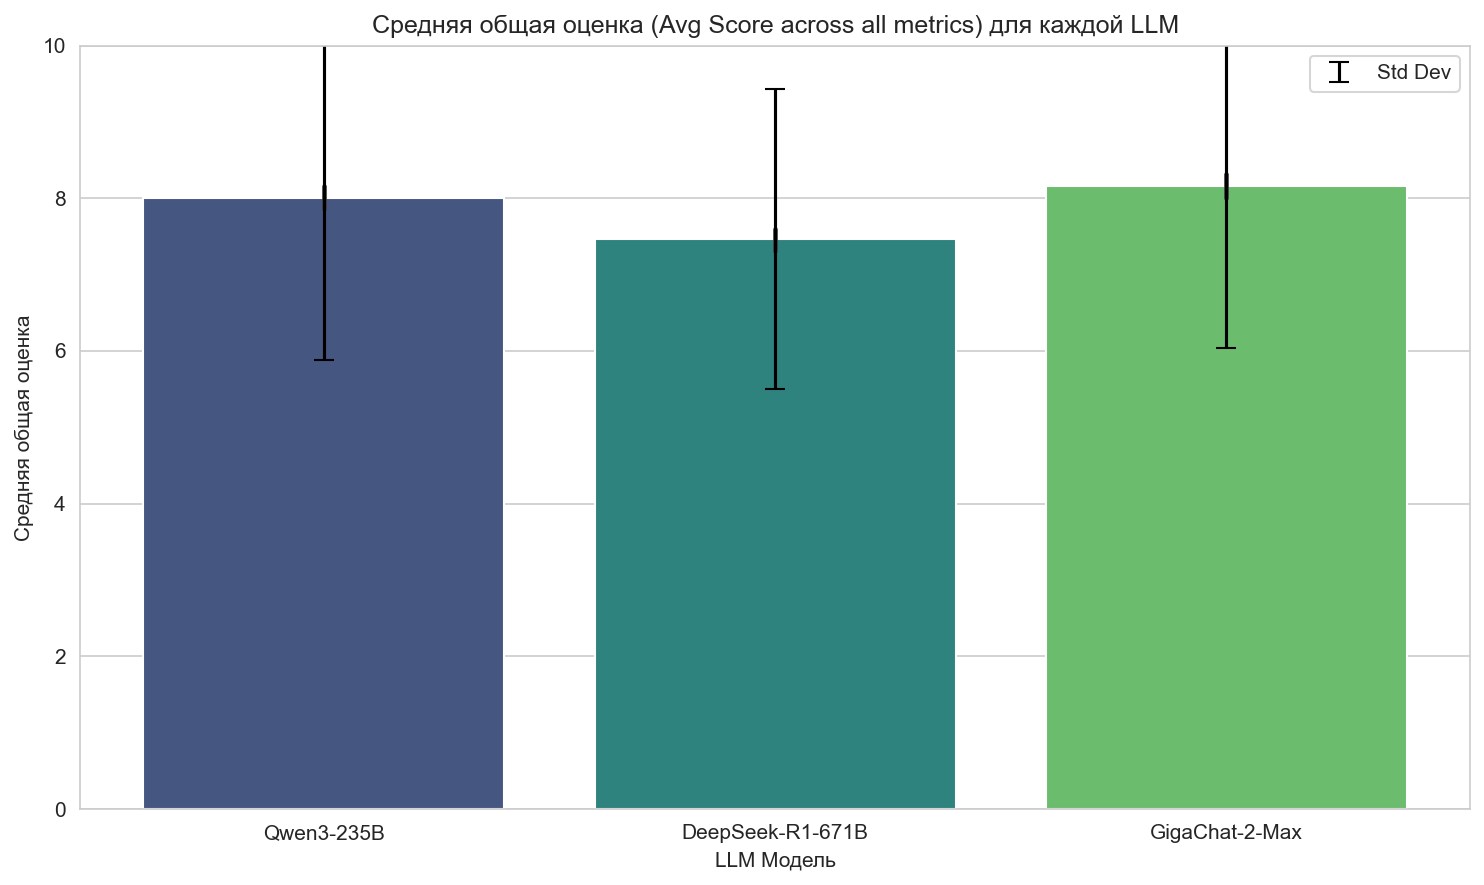

In [4]:
print("\nАнализ общей оценки генеративного ответа:")
overall_performance = combined_df.groupby('model')['average_overall_score'].agg(['mean', 'std']).sort_values(by='mean', ascending=False)
print("\nСредняя общая оценка и стандартное отклонение для каждой модели:")
print(overall_performance)

plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='average_overall_score', data=combined_df, estimator=lambda x: x.mean(), palette='viridis')
plt.errorbar(x=overall_performance.index, y=overall_performance['mean'], yerr=overall_performance['std'], fmt='none', c='black', capsize=5, label='Std Dev')
plt.title('Средняя общая оценка (Avg Score across all metrics) для каждой LLM')
plt.xlabel('LLM Модель')
plt.ylabel('Средняя общая оценка')
plt.ylim(0, 10)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
print("\nАнализ оценки по отдельным метрикам:")
metric_performance = combined_df.groupby('model')[score_columns].mean()
print("\nСредние оценки по каждой метрике для каждой модели:")
print(metric_performance)

melted_df = combined_df.melt(
    id_vars=['model', 'repo', 'element_id'], value_vars=score_columns,
    var_name='metric', value_name='score'
)

plt.figure(figsize=(14, 8))
sns.barplot(x='metric', y='score', hue='model', data=melted_df, palette='magma')
plt.title('Средние оценки по каждой метрике для каждой LLM')
plt.xlabel('Метрика')
plt.ylabel('Средняя оценка')
plt.ylim(0, 10)
plt.legend(title='LLM Модель', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Анализ оценки по отдельным метрикам:

Средние оценки по каждой метрике для каждой модели:
                  correctness  completeness  relevance   clarity  reasoning
model                                                                      
DeepSeek-R1-671B     7.216667      6.293056   8.790278  7.766667   7.240278
GigaChat-2-Max       8.038889      7.354167   8.937500  8.516667   7.968056
Qwen3-235B           7.602778      6.737500   9.084722  8.643056   7.963738



Анализ распределения оценок:


/var/folders/cl/dw0grtl92gb4bcfbmtz9jnwdkdqh1z/T/ipykernel_40335/3379707922.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='average_overall_score', data=combined_df, palette='cividis')


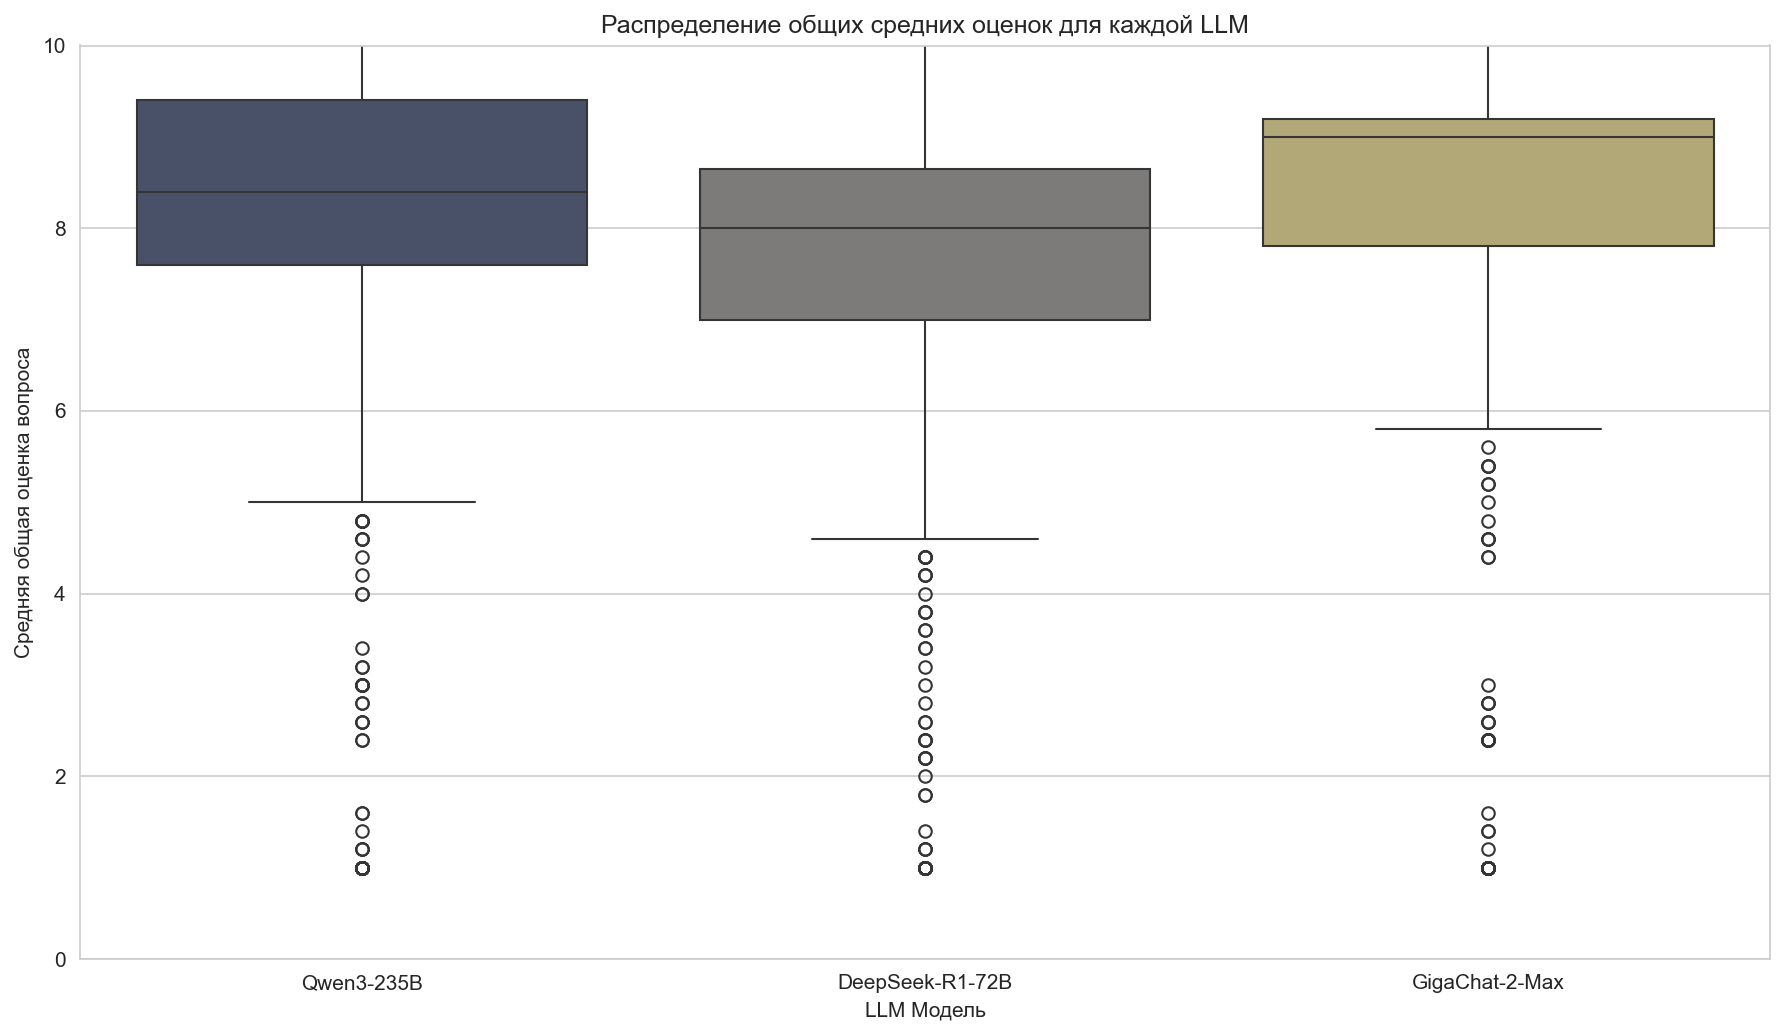

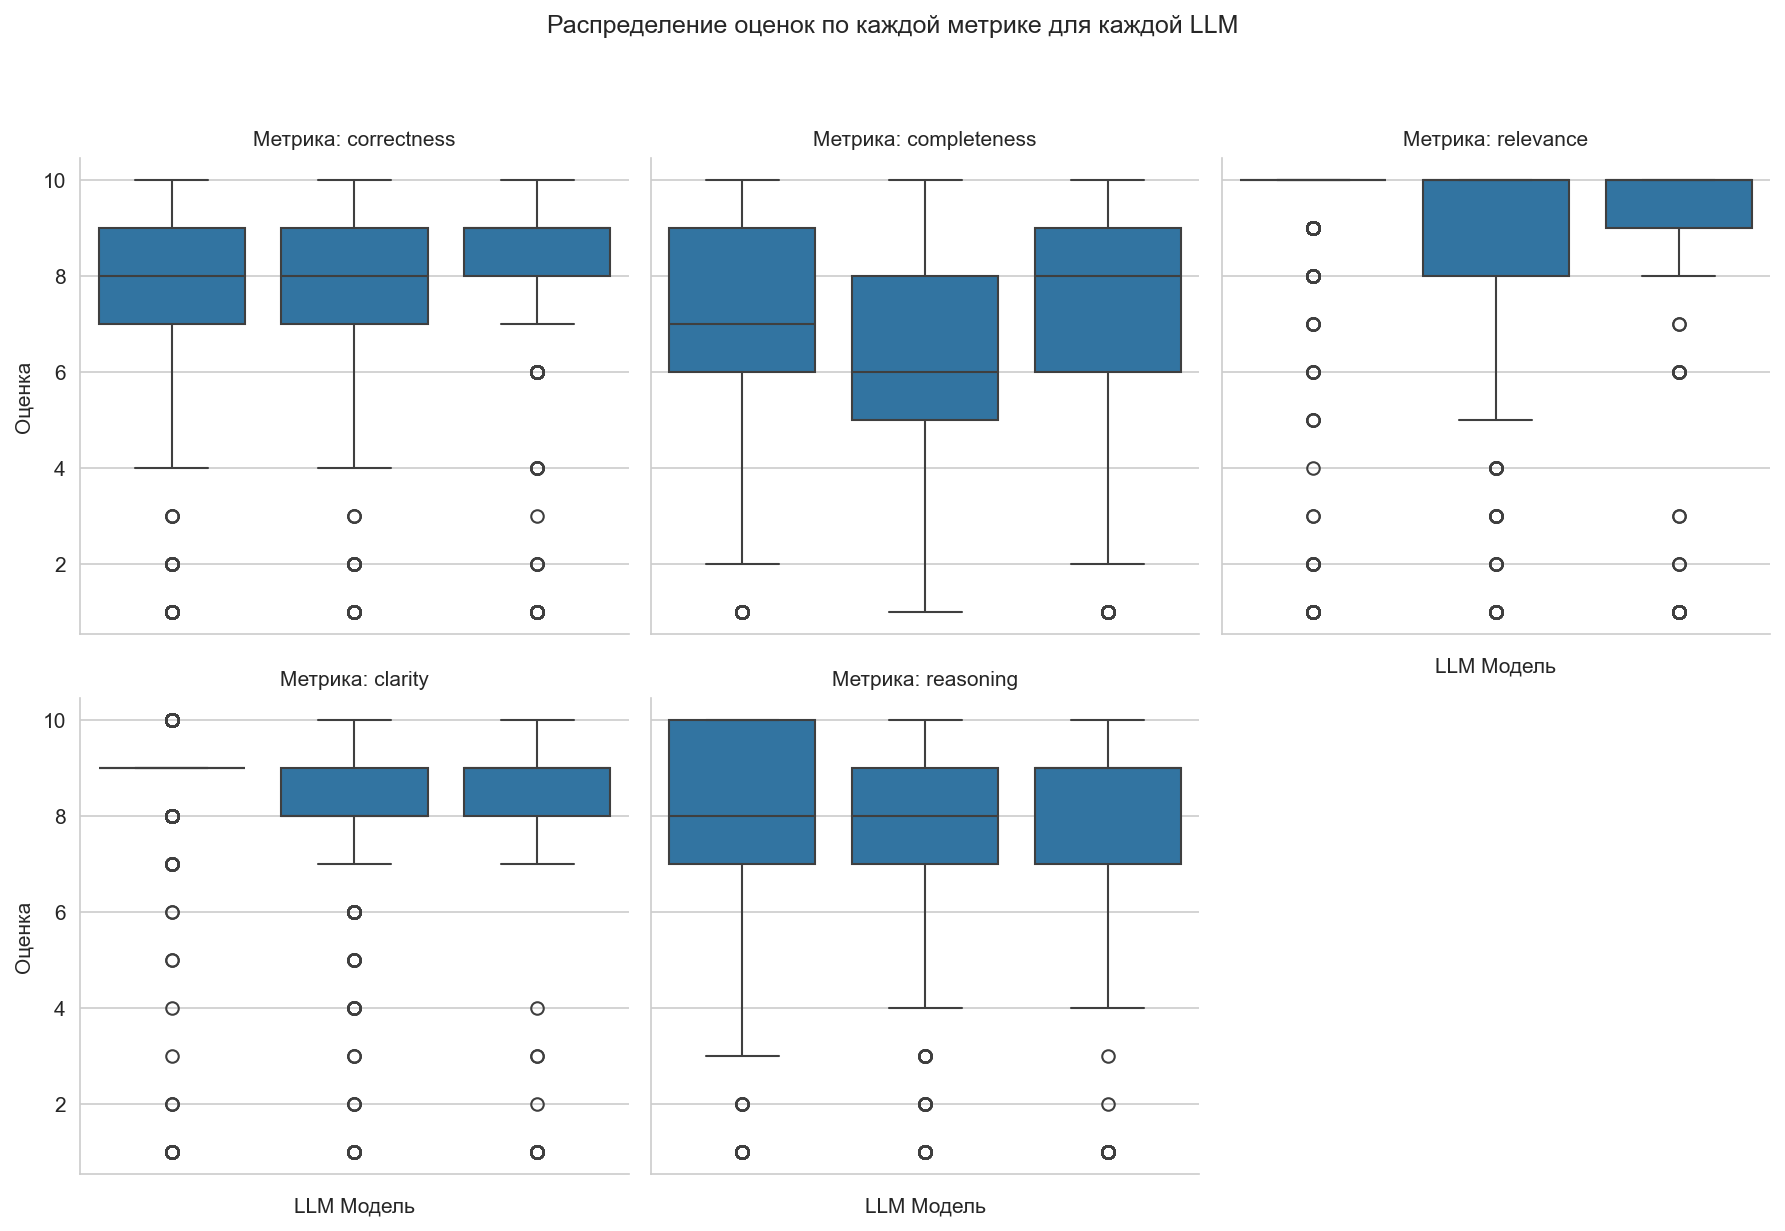

In [ ]:
print("\nАнализ распределения оценок:")
plt.figure(figsize=(12, 7))
sns.boxplot(x='model', y='average_overall_score', data=combined_df, palette='cividis')
plt.title('Распределение общих средних оценок для каждой LLM')
plt.xlabel('LLM Модель')
plt.ylabel('Средняя общая оценка вопроса')
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

g = sns.FacetGrid(melted_df, col='metric', col_wrap=3, height=4, sharey=True, palette='cividis')
g.map(sns.boxplot, 'model', 'score', order=combined_df['model'].unique())
g.set_axis_labels("LLM Модель", "Оценка")
g.set_titles("Метрика: {col_name}")
g.set_xticklabels(rotation=45, ha='right')
plt.suptitle('Распределение оценок по каждой метрике для каждой LLM', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


Анализ оценок в разрезе по репозиториям:

Средняя общая оценка по репозиториям для каждой модели:


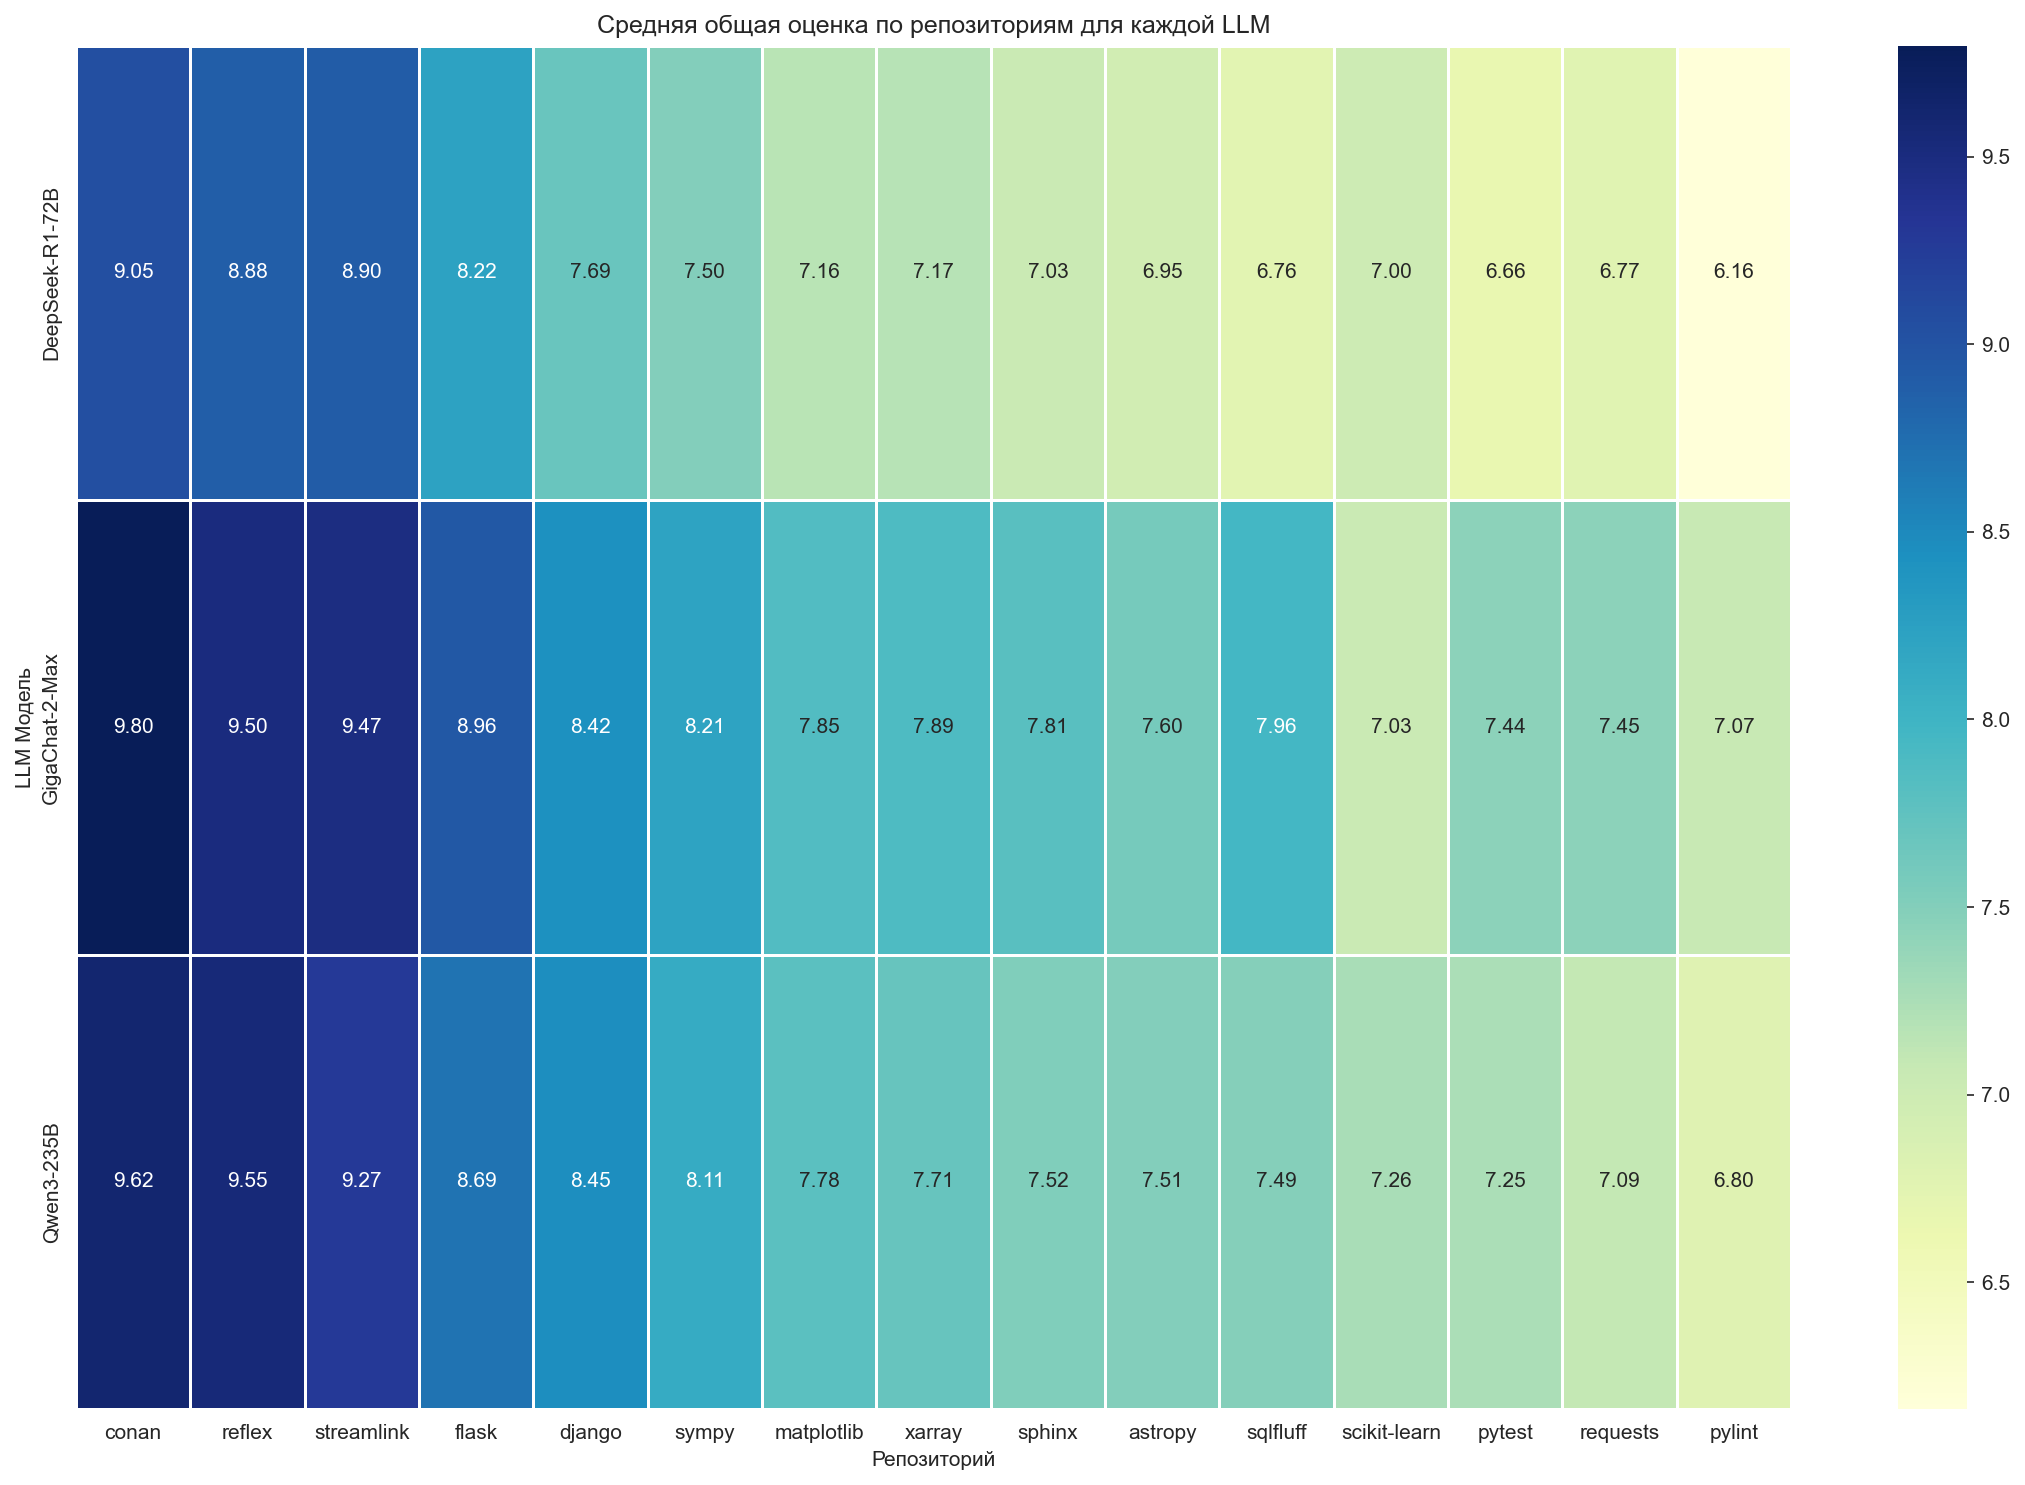

In [ ]:
print("\nАнализ оценок в разрезе по репозиториям:")
repo_performance = combined_df.groupby(['model', 'repo'])['average_overall_score'].mean().unstack()
print("\nСредняя общая оценка по репозиториям для каждой модели:")
repo_performance = repo_performance[[
    'conan',
    'reflex',
    'streamlink',
    'flask',
    'django',
    'sympy',
    'matplotlib',
    'xarray',
    'sphinx',
    'astropy',
    'sqlfluff',
    'scikit-learn',
    'pytest',
    'requests',
    'pylint'
]]

plt.figure(figsize=(15, 10))
sns.heatmap(repo_performance, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5)
plt.title('Средняя общая оценка по репозиториям для каждой LLM')
plt.xlabel('Репозиторий')
plt.ylabel('LLM Модель')
plt.tight_layout()
plt.show()

In [ ]:
# Если много вопросов, где все модели проваливаются, это могут быть:
#   а) Действительно очень сложные вопросы.
#   б) Плохо сформулированные вопросы или вопросы, требующие уникальных знаний, отсутствующих в RAG-контексте.
# Если много вопросов, где все модели превосходны, это могут быть:
#   а) Очень простые вопросы.
#   б) Вопросы, которые хорошо покрываются базовыми знаниями моделей или легко находятся в контексте.
# Это позволяет оценить качество самого бенчмарка или выявить области для дальнейшего улучшения контекста RAG.

print("\n--- Анализ экстремальных вопросов (для всех моделей) ---")
question_scores_per_model = combined_df.groupby(['repo', 'element_id', 'model'])['average_overall_score'].mean().unstack(level='model')
total_unique_questions = combined_df[['repo', 'element_id']].drop_duplicates().shape[0]

# Определяем пороговые значения для "очень низких" и "очень высоких" оценок (на шкале 0-10)
low_threshold = 1.0
high_threshold = 10.0

# Вопросы, где ВСЕ модели получили оценку НИЖЕ или РАВНУЮ low_threshold
low_performance_questions = question_scores_per_model[
    (question_scores_per_model <= low_threshold).all(axis=1)
]
prop_low = len(low_performance_questions) / total_unique_questions if total_unique_questions > 0 else 0

print(f"\nВопросы, где ВСЕ модели показали очень низкую среднюю общую оценку (<= {low_threshold}):")
print(f"  Количество таких вопросов: {len(low_performance_questions)}")
print(f"  Доля от общего числа вопросов: {prop_low:.2%}")
if not low_performance_questions.empty:
    print("  Примеры таких вопросов (repo, element_id):")
    print(low_performance_questions.head())


--- Анализ экстремальных вопросов (для всех моделей) ---

Вопросы, где ВСЕ модели показали очень низкую среднюю общую оценку (<= 1.0):
  Количество таких вопросов: 23
  Доля от общего числа вопросов: 3.19%
  Примеры таких вопросов (repo, element_id):
model               DeepSeek-R1-72B  GigaChat-2-Max  Qwen3-235B
repo    element_id                                             
astropy 4                       1.0             1.0         1.0
        9                       1.0             1.0         1.0
        11                      1.0             1.0         1.0
        14                      1.0             1.0         1.0
        19                      1.0             1.0         1.0


In [ ]:
# Вопросы, где ВСЕ модели получили оценку ВЫШЕ или РАВНУЮ high_threshold
high_performance_questions = question_scores_per_model[
    (question_scores_per_model >= high_threshold).all(axis=1)
]
prop_high = len(high_performance_questions) / total_unique_questions if total_unique_questions > 0 else 0

print(f"\nВопросы, где ВСЕ модели показали очень высокую среднюю общую оценку (>= {high_threshold}):")
print(f"  Количество таких вопросов: {len(high_performance_questions)}")
print(f"  Доля от общего числа вопросов: {prop_high:.2%}")
if not high_performance_questions.empty:
    print("  Примеры таких вопросов (repo, element_id):")
    print(high_performance_questions.head())


Вопросы, где ВСЕ модели показали очень высокую среднюю общую оценку (>= 10.0):
  Количество таких вопросов: 17
  Доля от общего числа вопросов: 2.36%
  Примеры таких вопросов (repo, element_id):
model               DeepSeek-R1-72B  GigaChat-2-Max  Qwen3-235B
repo    element_id                                             
astropy 45                     10.0            10.0        10.0
        46                     10.0            10.0        10.0
conan   14                     10.0            10.0        10.0
        17                     10.0            10.0        10.0
        26                     10.0            10.0        10.0



--- Корреляция средних общих оценок между LLM ---

Матрица корреляции средних общих оценок:
model            DeepSeek-R1-72B  GigaChat-2-Max  Qwen3-235B
model                                                       
DeepSeek-R1-72B         1.000000        0.923205    0.936729
GigaChat-2-Max          0.923205        1.000000    0.937011
Qwen3-235B              0.936729        0.937011    1.000000


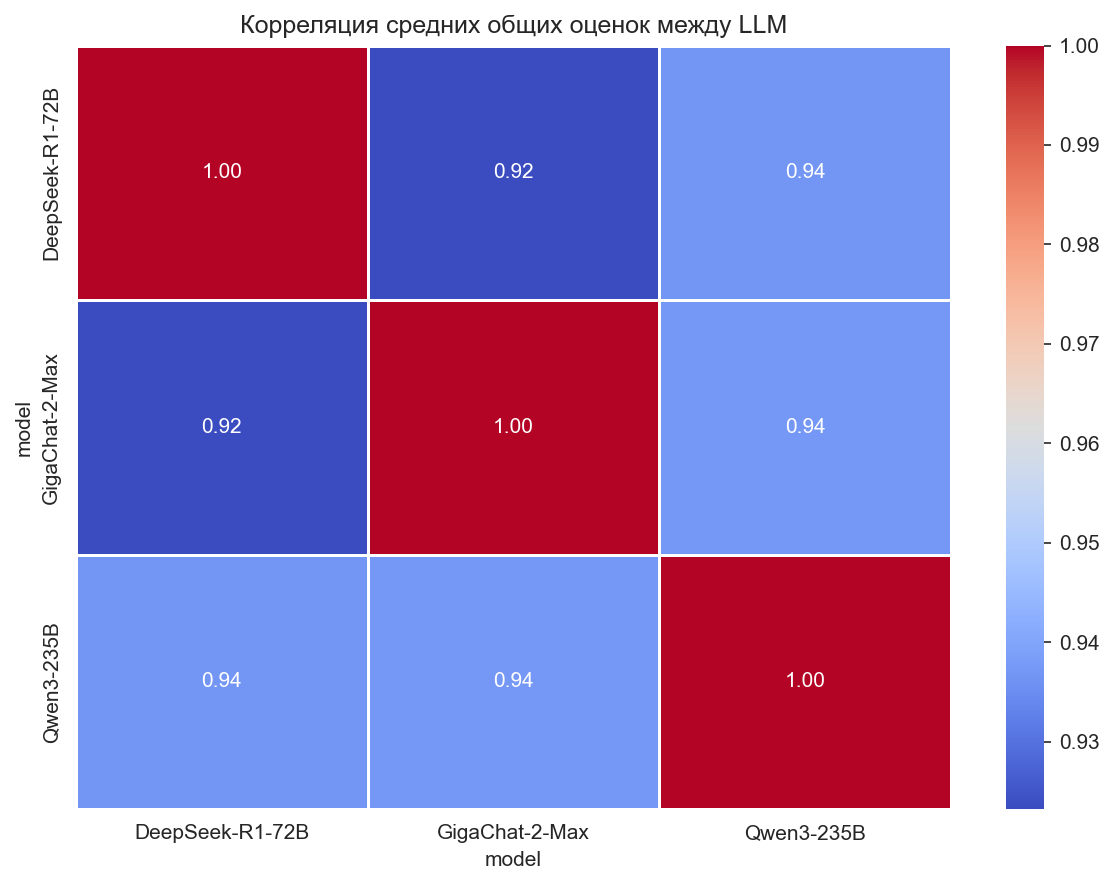


Аналитика завершена.


In [ ]:
# --- НОВАЯ МЕТРИКА 6: Корреляция оценок между разными моделями ---
# Почему это важно: Показывает степень согласия между оценками различных моделей.
# Высокая положительная корреляция (близкая к 1) означает, что модели, как правило,
# дают похожие оценки на один и тот же вопрос – если одна модель хороша, то и другая, скорее всего, тоже.
# Низкая или отрицательная корреляция указывает на то, что модели по-разному реагируют на вопросы,
# возможно, демонстрируя разные сильные стороны, или на то, что их системы оценки имеют существенные расхождения.
# Это может быть полезно для выбора наиболее "разнообразных" моделей для ансамблирования или для
# глубокого анализа причин расхождений в оценках.

print("\n--- Корреляция средних общих оценок между LLM ---")
if not question_scores_per_model.empty:
    correlation_matrix = question_scores_per_model.corr()
    print("\nМатрица корреляции средних общих оценок:")
    print(correlation_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Корреляция средних общих оценок между LLM')
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для расчета корреляции.")

print("\nАналитика завершена.")